In [ ]:
! pip install geopandas
! pip install geodatasets
! pip install kagglehub

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import geopandas as gpd
import geodatasets
import requests
import io
import shutil
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Data Preparation

In [ ]:
# Load data
dataset_path = kagglehub.dataset_download("manchunhui/us-election-2020-tweets")

In [ ]:
# List files to see the contents
files = os.listdir(dataset_path)
print("Files in dataset:", files)

biden_tweets = pd.read_csv(dataset_path+"/hashtag_joebiden.csv",lineterminator='\n')
trump_tweets = pd.read_csv(dataset_path+"/hashtag_donaldtrump.csv",lineterminator='\n')


Files in dataset: ['hashtag_donaldtrump.csv', 'hashtag_joebiden.csv']


In [ ]:
biden_tweets['created_at'] = pd.to_datetime(biden_tweets['created_at'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
trump_tweets['created_at'] = pd.to_datetime(trump_tweets['created_at'], format="%Y-%m-%d %H:%M:%S", errors='coerce')


data_biden = biden_tweets.dropna(subset=['created_at'])
data_trump = trump_tweets.dropna(subset=['created_at'])

# Remove duplicate tweets
data_biden = data_biden.drop_duplicates(subset='tweet_id', keep='first')
data_trump = data_trump.drop_duplicates(subset='tweet_id', keep='first')

# Check for missing values in crucial columns
print("Missing Values in Biden Data:")
print(data_biden.isnull().sum())

print("Missing Values in Trump Data:")
print(data_trump.isnull().sum())

# Remove rows with NA values in essential columns (like 'tweet', 'likes', etc.)
data_biden = data_biden.dropna(subset=['tweet', 'likes', 'retweet_count'])
data_trump = data_trump.dropna(subset=['tweet', 'likes', 'retweet_count'])

Missing Values in Biden Data:
created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     711
user_id                      0
user_name                   25
user_screen_name             0
user_description         81865
user_join_date               0
user_followers_count         0
user_location           233299
lat                     420709
long                    420709
city                    588523
country                 422221
continent               422203
state                   515356
state_code              530911
collected_at                 0
dtype: int64
Missing Values in Trump Data:
created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     876
user_id                      0
user_name                   22
user_screen_name            

In [ ]:
data_biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [ ]:
data_biden['candidate'] = 'Biden'
data_trump['candidate'] = 'Trump'

tweets = pd.concat([data_biden, data_trump], ignore_index=True)

# Exploratory Data Analysis

In [ ]:
# Basic information about dataset
print(tweets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744609 entries, 0 to 1744608
Data columns (total 22 columns):
 #   Column                Dtype         
---  ------                -----         
 0   created_at            datetime64[ns]
 1   tweet_id              float64       
 2   tweet                 object        
 3   likes                 float64       
 4   retweet_count         float64       
 5   source                object        
 6   user_id               float64       
 7   user_name             object        
 8   user_screen_name      object        
 9   user_description      object        
 10  user_join_date        object        
 11  user_followers_count  float64       
 12  user_location         object        
 13  lat                   float64       
 14  long                  float64       
 15  city                  object        
 16  country               object        
 17  continent             object        
 18  state                 object        
 19  

## Missing Data - Location

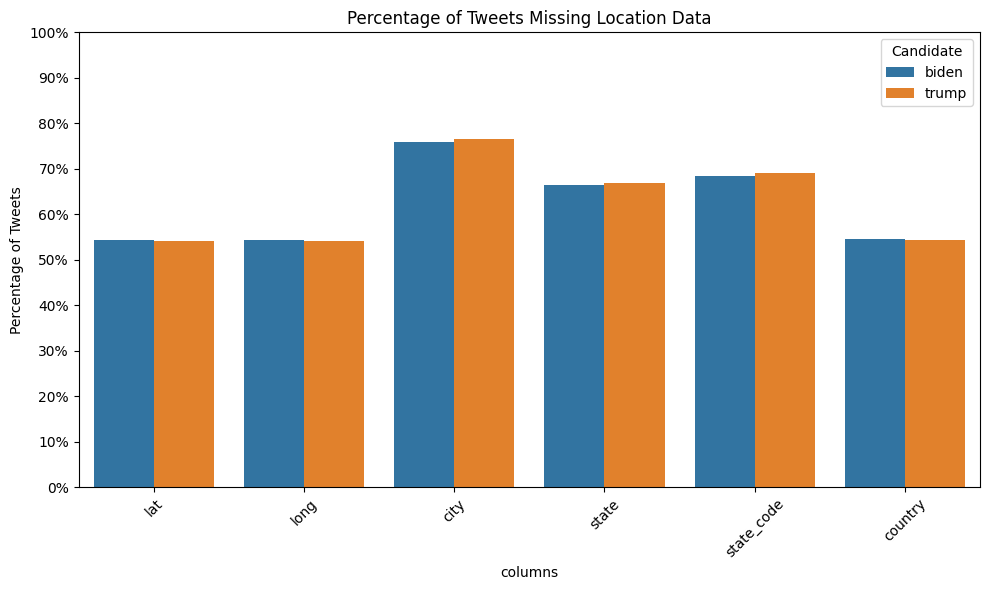

In [ ]:
def normalized_sum(x):
    missing = x.isnull().sum()
    total = len(x)
    output = missing / total if total > 0 else np.nan
    return output

# Assuming data_biden and data_trump are already defined as pandas DataFrames

columns = ["lat", "long", "city", "state", "state_code", "country"]

na_biden_sums = data_biden[columns].apply(normalized_sum)
na_biden = pd.DataFrame({'columns': na_biden_sums.index, 'na_sum': na_biden_sums.values})
na_biden['candidate'] = "biden"

na_trump_sums = data_trump[columns].apply(normalized_sum)
na_trump = pd.DataFrame({'columns': na_trump_sums.index, 'na_sum': na_trump_sums.values})
na_trump['candidate'] = "trump"

na_data = pd.concat([na_biden, na_trump])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=na_data, x='columns', y='na_sum', hue='candidate')
plt.title('Percentage of Tweets Missing Location Data')
plt.ylabel('Percentage of Tweets')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1), [f'{int(x*100)}%' for x in np.arange(0, 1.1, 0.1)])
plt.xticks(rotation=45)
plt.legend(title='Candidate')
plt.tight_layout()
plt.show()

## Statewise

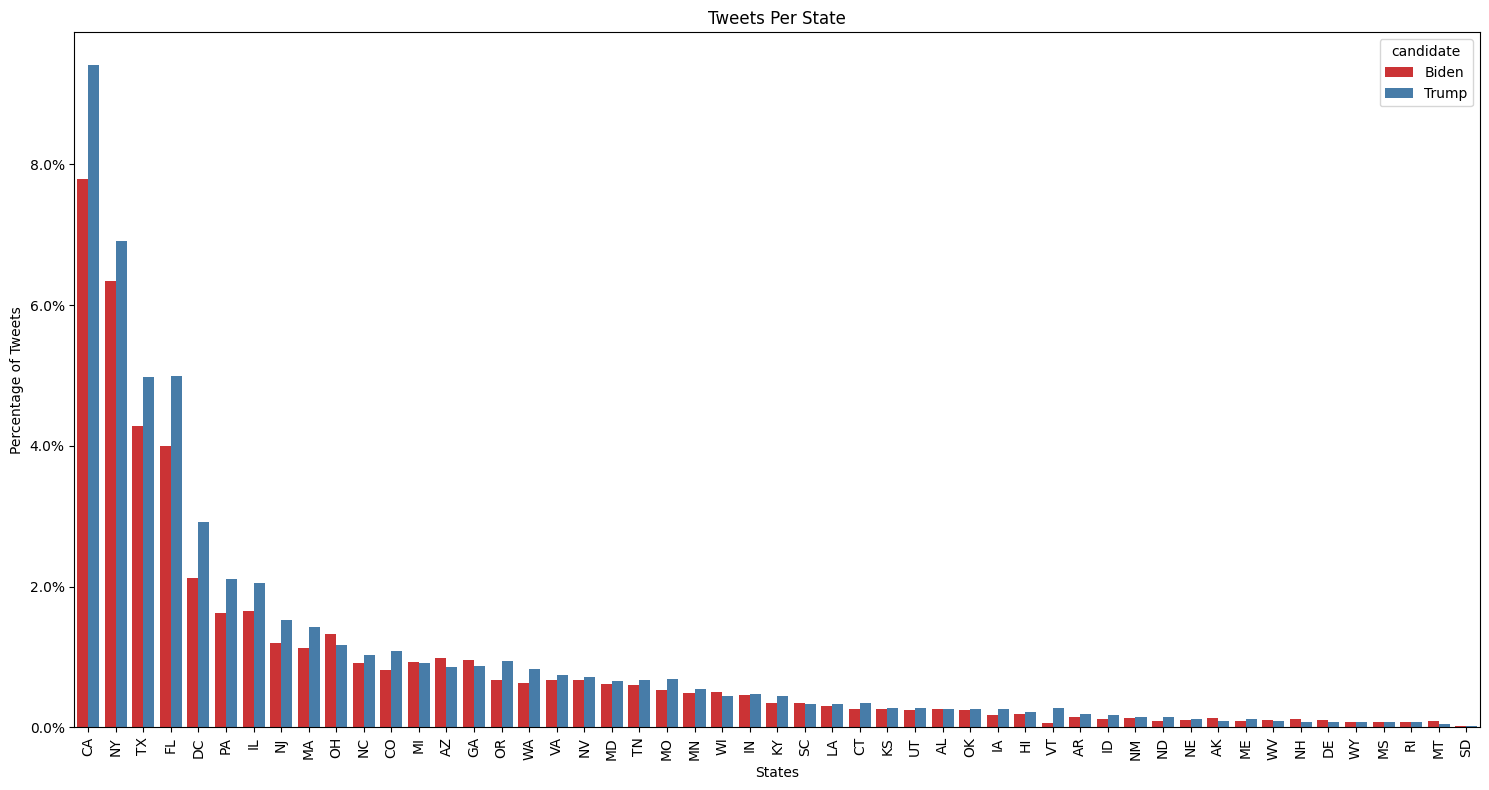

In [ ]:
def filter_loc(df):
    return df[
        (~df['state_code'].isin(['', 'PR', 'MP', 'GU'])) &
        (df['country'].isin(['United States', 'United States of America']))
    ]

us_biden = filter_loc(data_biden)
us_trump = filter_loc(data_trump)

us_data = pd.concat([us_biden, us_trump])
state_counts = us_data.groupby(['state_code', 'candidate']).size().unstack(fill_value=0)
state_percentages = state_counts.div(state_counts.sum().sum()) * 100

state_order = state_percentages.sum(axis=1).sort_values(ascending=False).index

plt.figure(figsize=(15, 8))
ax = sns.barplot(x='state_code', y='percentage', hue='candidate',
                 data=state_percentages.reset_index().melt(id_vars='state_code', var_name='candidate', value_name='percentage'),
                 order=state_order, palette='Set1')

plt.title('Tweets Per State')
plt.xlabel('States')
plt.ylabel('Percentage of Tweets')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

plt.tight_layout()
plt.show()

## Tweet pattern over time

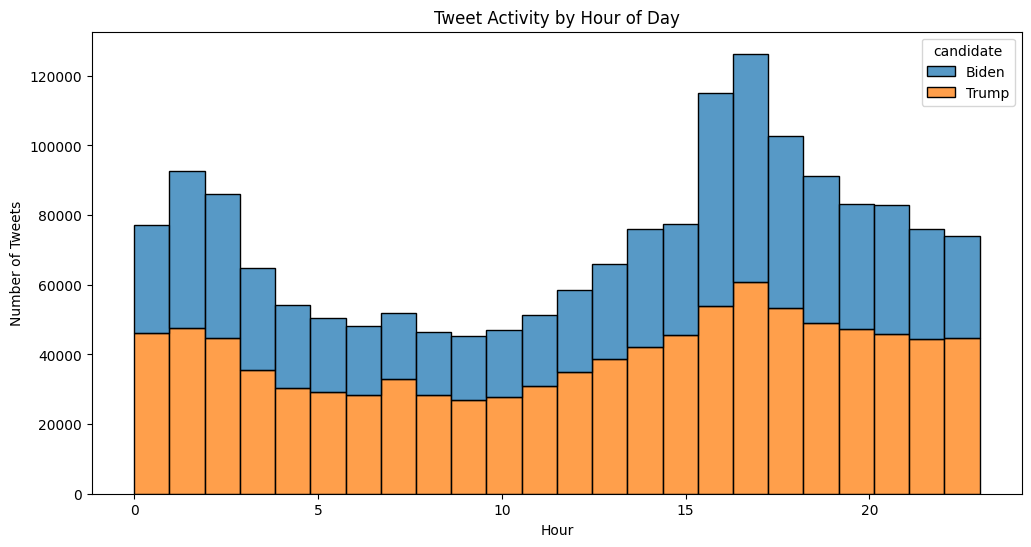

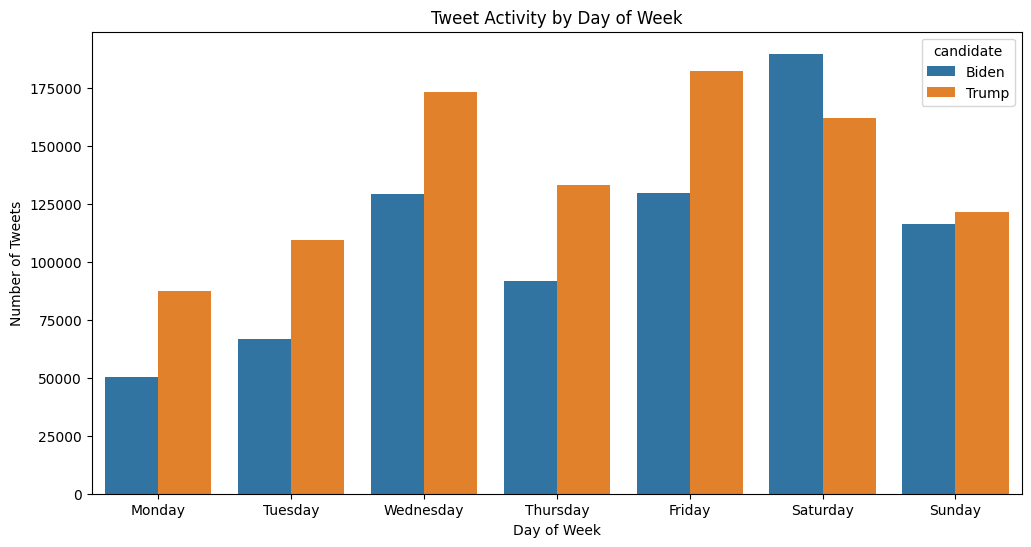

In [ ]:
# Convert 'created_at' to datetime format
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

# Extract hour and day of the week for additional insights
tweets['hour'] = tweets['created_at'].dt.hour
tweets['day_of_week'] = tweets['created_at'].dt.day_name()

# Plot hourly activity
plt.figure(figsize=(12, 6))
sns.histplot(data=tweets, x='hour', hue='candidate', multiple='stack', bins=24)
plt.title("Tweet Activity by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Tweets")
plt.show()

# Plot day of week activity
plt.figure(figsize=(12, 6))
sns.countplot(data=tweets, x='day_of_week', hue='candidate', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Tweet Activity by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Tweets")
plt.show()


## Distribution of likes

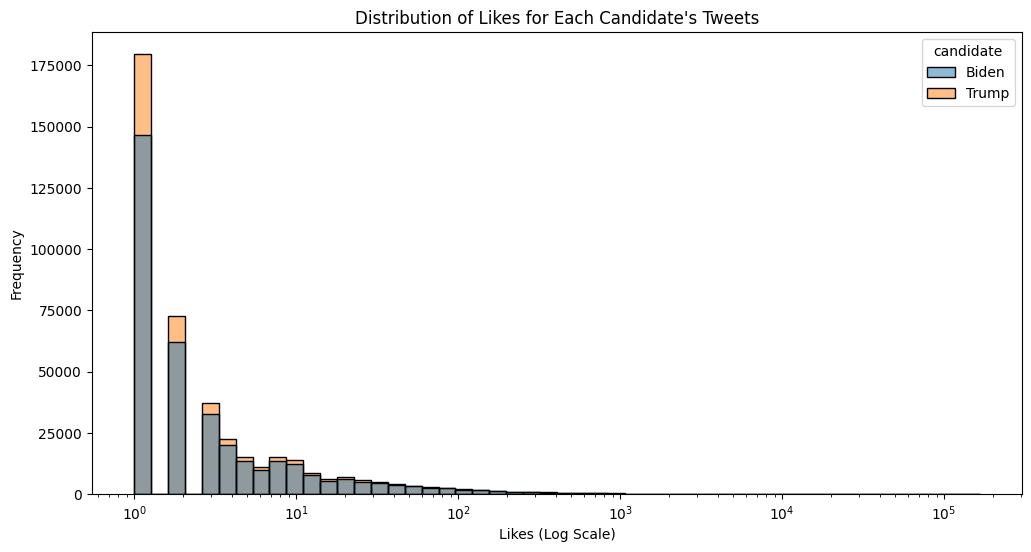

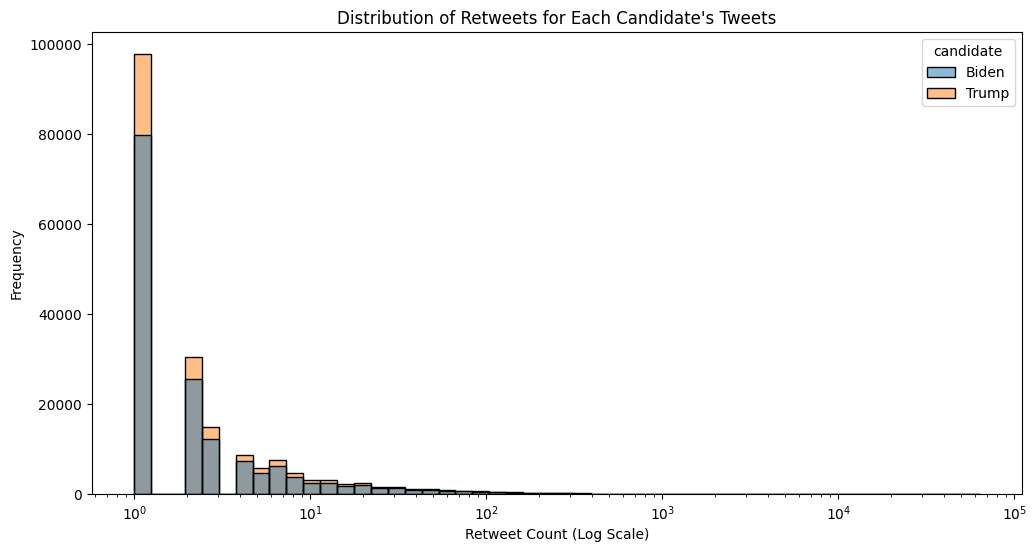

Average Likes and Retweets per Candidate:
  candidate      likes  retweet_count
0     Biden  10.171838       2.132366
1     Trump   7.483770       1.699731


In [ ]:
# Likes distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=tweets, x='likes', hue='candidate', log_scale=True, bins=50)
plt.title("Distribution of Likes for Each Candidate's Tweets")
plt.xlabel("Likes (Log Scale)")
plt.ylabel("Frequency")
plt.show()
print("\n\n\n")
# Retweets distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=tweets, x='retweet_count', hue='candidate', log_scale=True, bins=50)
plt.title("Distribution of Retweets for Each Candidate's Tweets")
plt.xlabel("Retweet Count (Log Scale)")
plt.ylabel("Frequency")
plt.show()

# Average engagement metrics
engagement_summary = tweets.groupby('candidate')[['likes', 'retweet_count']].mean().reset_index()
print("Average Likes and Retweets per Candidate:")
print(engagement_summary)


## User Demographic

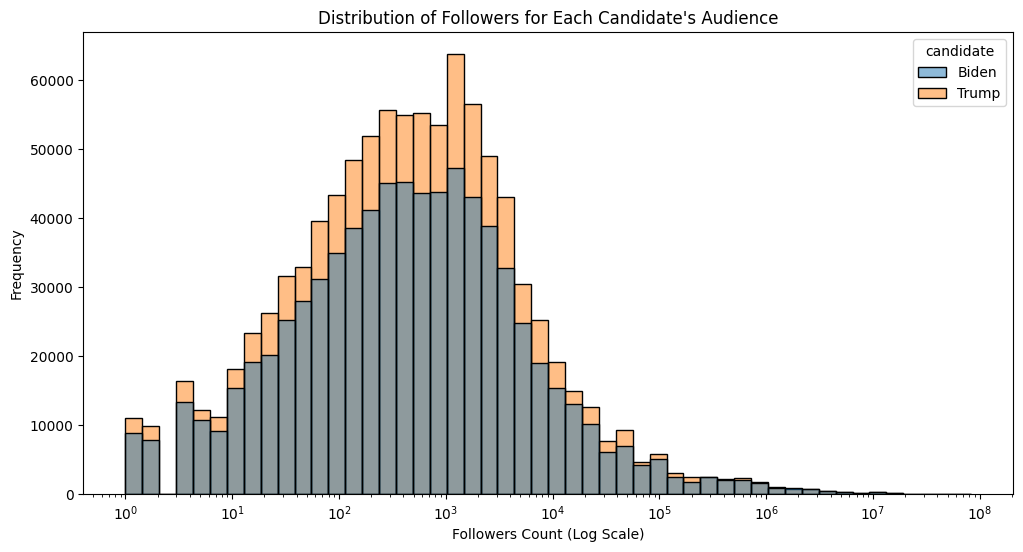

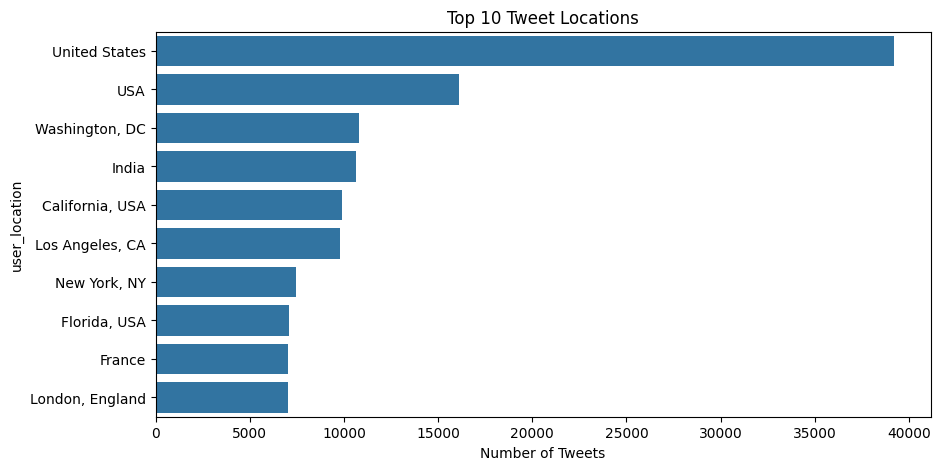

In [ ]:
# Followers distribution (log scale for visualization)
plt.figure(figsize=(12, 6))
sns.histplot(data=tweets, x='user_followers_count', hue='candidate', log_scale=True, bins=50)
plt.title("Distribution of Followers for Each Candidate's Audience")
plt.xlabel("Followers Count (Log Scale)")
plt.ylabel("Frequency")
plt.show()
print("\n\n\n")
# Top 10 locations
top_locations = tweets['user_location'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.title("Top 10 Tweet Locations")
plt.xlabel("Number of Tweets")
plt.show()


## Source Analysis

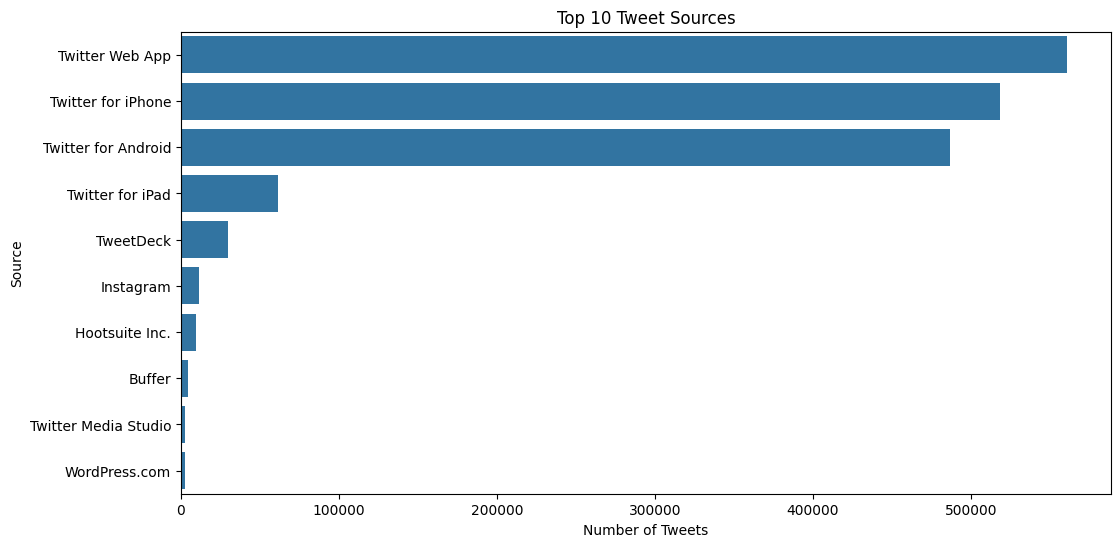

In [ ]:
# Top 10 sources
top_sources = tweets['source'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_sources.values, y=top_sources.index)
plt.title("Top 10 Tweet Sources")
plt.xlabel("Number of Tweets")
plt.ylabel("Source")
plt.show()


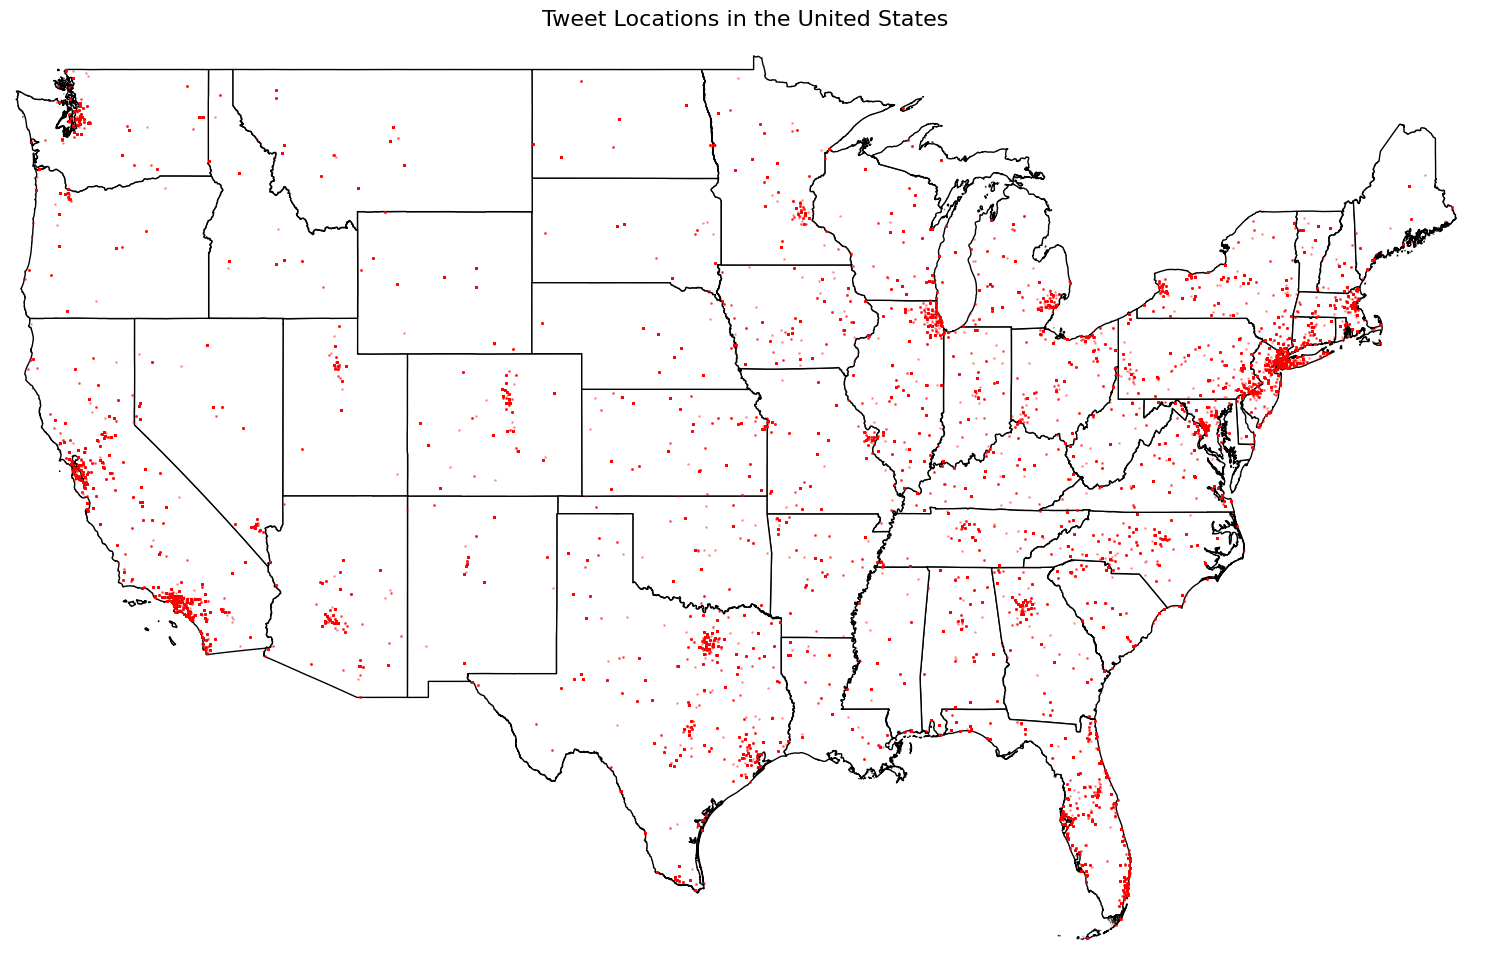

In [ ]:
us_data['lat'] = pd.to_numeric(us_data['lat'], errors='coerce')
us_data['long'] = pd.to_numeric(us_data['long'], errors='coerce')

gdf_tweets = gpd.GeoDataFrame(
    us_data, geometry=gpd.points_from_xy(us_data.long, us_data.lat), crs="EPSG:4326"
)

url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall("us_states_shapefile")

us_states = gpd.read_file("us_states_shapefile/cb_2020_us_state_500k.shp")

fig, ax = plt.subplots(figsize=(15, 10))

us_states.plot(ax=ax, color='white', edgecolor='black')

gdf_tweets.plot(ax=ax, color='red', alpha=0.3, markersize=1)

ax.set_xlim(-125, -66)
ax.set_ylim(24, 50)

ax.axis('off')

plt.title('Tweet Locations in the United States', fontsize=16)

plt.tight_layout()
plt.show()
shutil.rmtree("us_states_shapefile")

## Duplicate Tweets (Tweets present in both Trump dataset and Biden dataset)

<ipython-input-17-5c67cbe9f4b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biden_only['candidate'] = 'biden'
<ipython-input-17-5c67cbe9f4b0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_only['candidate'] = 'trump'
<ipython-input-17-5c67cbe9f4b0>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([f'{x:.0f}%' for x in g.get_yticks()])


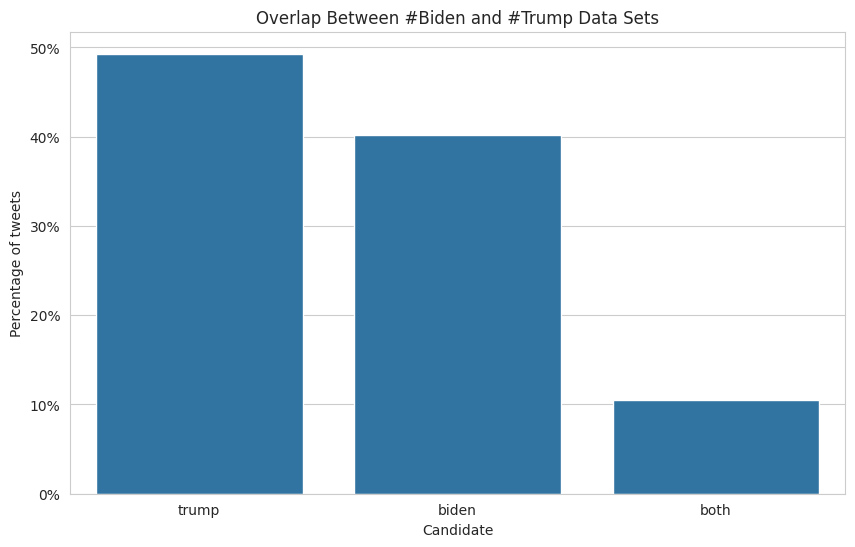

In [ ]:
us_biden = us_biden[data_biden.columns]
us_trump = us_trump[data_trump.columns]

# Combine and get unique tweets
total_unique = pd.concat([us_biden, us_trump]).drop_duplicates(subset='tweet_id')

# Get tweets unique to Biden
biden_only = us_biden[~us_biden['tweet_id'].isin(us_trump['tweet_id'])]
biden_only['candidate'] = 'biden'

# Get tweets unique to Trump
trump_only = us_trump[~us_trump['tweet_id'].isin(us_biden['tweet_id'])]
trump_only['candidate'] = 'trump'

# Get tweets in both datasets
both_only = pd.merge(us_biden, us_trump, on='tweet_id')
both_only['candidate'] = 'both'

# Combine all datasets
separated_data = pd.concat([biden_only, trump_only, both_only])

# Convert candidate to categorical type with specific order
separated_data['candidate'] = pd.Categorical(separated_data['candidate'],
                                             categories=['trump', 'biden', 'both'],
                                             ordered=True)

# Create the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
g = sns.barplot(x='candidate', y='tweet_id', data=separated_data,
                estimator=lambda x: len(x) / len(separated_data) * 100)
plt.title("Overlap Between #Biden and #Trump Data Sets")
plt.ylabel("Percentage of tweets")
plt.xlabel("Candidate")
g.set_yticklabels([f'{x:.0f}%' for x in g.get_yticks()])
plt.show()

In [ ]:
us_data.columns

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at', 'candidate'],
      dtype='object')

# Sentiment Analysis (Vader)

<ipython-input-19-f6d24fddbfe7>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['created_at_hour'] = df['created_at'].dt.floor('H')
<ipython-input-19-f6d24fddbfe7>:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['created_at_hour'] = df['created_at'].dt.floor('H')


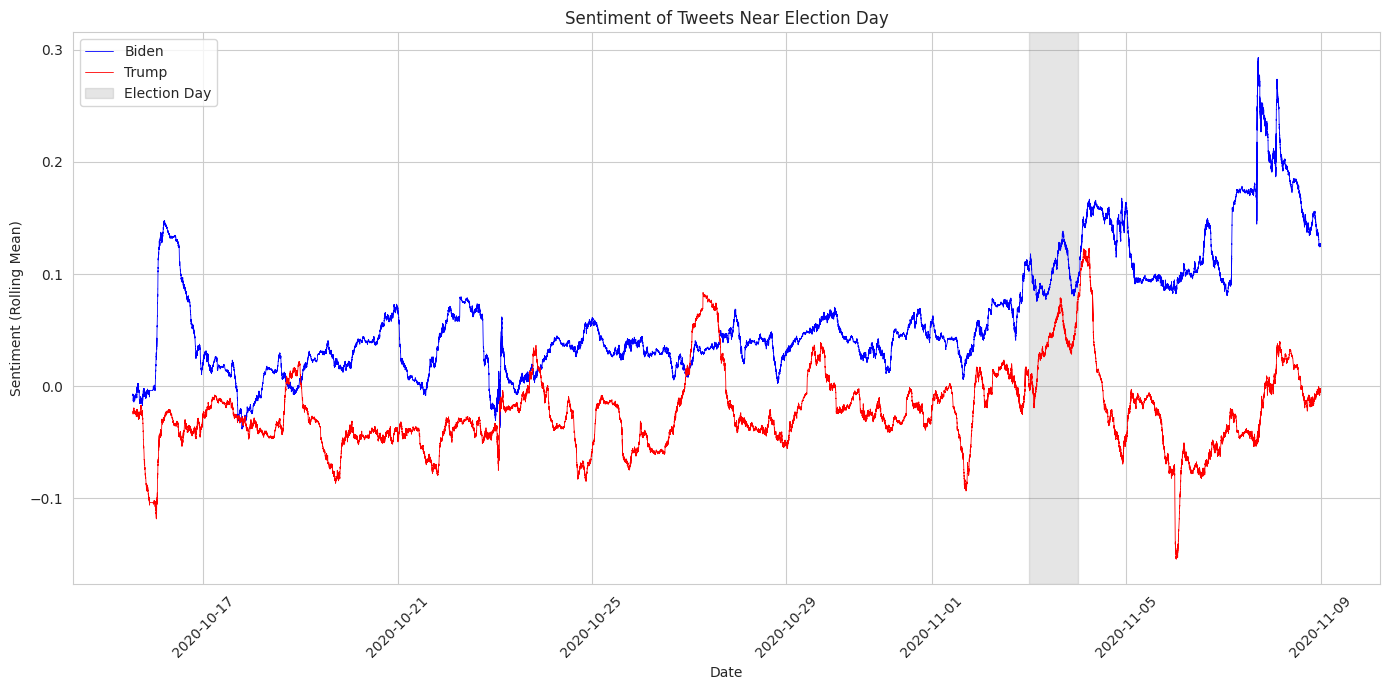

In [ ]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from random import sample
import matplotlib.pyplot as plt
import datetime as dt

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def tweet_sentiment(text):
    sentiment_score = analyzer.polarity_scores(str(text))
    return sentiment_score['compound']  # Use compound score

# Sample the data (100% sampling in this case)
sample_data = separated_data.sample(frac=1.0, random_state=42).copy()

sample_data['sentiment'] = sample_data['tweet'].apply(tweet_sentiment)

sample_data['created_at'] = pd.to_datetime(sample_data['created_at'])

tmp_biden = sample_data[sample_data['candidate'] == 'biden'].sort_values('created_at')
tmp_trump = sample_data[sample_data['candidate'] == 'trump'].sort_values('created_at')

# Function to calculate average tweets per hour
def avg_tweets_per_hour(df):
    if df.empty:
        return np.nan
    df['created_at_hour'] = df['created_at'].dt.floor('H')
    avg_tph = df.groupby('created_at_hour').size().mean()
    return avg_tph

biden_tph = avg_tweets_per_hour(tmp_biden)
trump_tph = avg_tweets_per_hour(tmp_trump)

default_window = 24 #24 hour window

# Rolling averages
tmp_biden['rollmean'] = tmp_biden['sentiment'].rolling(window=int(8 * biden_tph) if not np.isnan(biden_tph) else default_window).mean()
tmp_trump['rollmean'] = tmp_trump['sentiment'].rolling(window=int(8 * trump_tph) if not np.isnan(trump_tph) else default_window).mean()
sample_data = pd.concat([tmp_biden, tmp_trump])

# Plot
plt.figure(figsize=(14, 7))

plt.plot(tmp_biden['created_at'], tmp_biden['rollmean'], label='Biden', color='blue', linewidth=0.6)
plt.plot(tmp_trump['created_at'], tmp_trump['rollmean'], label='Trump', color='red', linewidth=0.6)
plt.axvspan(pd.Timestamp('2020-11-03'), pd.Timestamp('2020-11-04'), color='grey', alpha=0.2, label='Election Day')
plt.title('Sentiment of Tweets Near Election Day')
plt.xlabel('Date')
plt.ylabel('Sentiment (Rolling Mean)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
sample_data['candidate'].value_counts()

,count
candidate,
trump,175275
biden,143043
both,0


# Prediction

In [ ]:
path = kagglehub.dataset_download("unanimad/us-election-2020")


In [ ]:
os.listdir(path+"/")

['president_county_candidate.csv',
 'house_state.csv',
 'senate_county.csv',
 'house_candidate.csv',
 'governors_state.csv',
 'governors_county_candidate.csv',
 'senate_county_candidate.csv',
 'governors_county.csv',
 'senate_state.csv',
 'president_county.csv',
 'president_state.csv']

In [ ]:
president_state = pd.read_csv(path+"/president_state.csv")
president_county_candidate = pd.read_csv(path+"/president_county_candidate.csv")

In [ ]:
president_state.head()

,state,total_votes
0,Delaware,504010
1,District of Columbia,344356
2,Florida,11067456
3,Georgia,4997716
4,Hawaii,574469


In [ ]:
president_county_candidate.rename(columns={'total_votes': 'total_candidate_votes'}, inplace=True)

biden_votes = president_county_candidate[president_county_candidate['candidate'] == "Joe Biden"]
trump_votes = president_county_candidate[president_county_candidate['candidate'] == "Donald Trump"]

def sum_by_states(df):
    state = df['state'].iloc[0]
    total_candidate_votes = df['total_candidate_votes'].sum()
    return pd.DataFrame({"state": [state], "total_candidate_votes": [total_candidate_votes]})

biden_votes_grouped = biden_votes.groupby('state').apply(sum_by_states).reset_index(drop=True)
trump_votes_grouped = trump_votes.groupby('state').apply(sum_by_states).reset_index(drop=True)

biden_votes = biden_votes_grouped.merge(president_state, on="state", how="inner")
trump_votes = trump_votes_grouped.merge(president_state, on="state", how="inner")

# Calculate vote percentages
biden_votes['vote_percent'] = (biden_votes['total_candidate_votes'] / biden_votes['total_votes']) * 100
trump_votes['vote_percent'] = (trump_votes['total_candidate_votes'] / trump_votes['total_votes']) * 100

# Calculate vote percentages
all_votes = biden_votes.merge(trump_votes, on="state", suffixes=(".biden", ".trump"))


<ipython-input-25-e998c0e1ed0c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  biden_votes_grouped = biden_votes.groupby('state').apply(sum_by_states).reset_index(drop=True)
<ipython-input-25-e998c0e1ed0c>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trump_votes_grouped = trump_votes.groupby('state').apply(sum_by_states).reset_index(drop=True)


In [ ]:
all_votes

,state,total_candidate_votes.biden,total_votes.biden,vote_percent.biden,total_candidate_votes.trump,total_votes.trump,vote_percent.trump
0,Alabama,849648,2323304,36.570677,1441168,2323304,62.030970
1,Alaska,153405,359530,42.668206,189892,359530,52.816733
2,Arizona,1672143,3387326,49.364691,1661686,3387326,49.055981
3,Arkansas,423932,1219069,34.775062,760647,1219069,62.395730
4,California,11109764,17495906,63.499221,6005961,17495906,34.327808
5,Colorado,1804352,3256953,55.400001,1364607,3256953,41.898271
6,Connecticut,1080680,1824280,59.238713,715291,1824280,39.209496
7,Delaware,296268,504010,58.782167,200603,504010,39.801393
8,District of Columbia,317323,344356,92.149694,18586,344356,5.397321
9,Florida,5297045,11067456,47.861451,5668731,11067456,51.219820


In [ ]:
import pandas as pd
import numpy as np

tmp_biden_range = tmp_biden[tmp_biden['created_at'] < "2020-11-03 00:00:00"] # tmp created in sentiment analysis
tmp_trump_range = tmp_trump[tmp_trump['created_at'] < "2020-11-03 00:00:00"]

# Split data by state
list_tmp_biden = tmp_biden_range.groupby('state')
list_tmp_trump = tmp_trump_range.groupby('state')

# Define function to calculate mean, median, and standard deviation for sentiment by state and candidate
def mean_by_state(df):
    state = df['state'].iloc[0]
    candidate = df['candidate'].iloc[0]
    mean_sentiment = df['sentiment'].mean()
    median_sentiment = df['sentiment'].median()
    sd_sentiment = df['sentiment'].std()

    output = pd.DataFrame({'state': [state]})

    if candidate == "biden":
        output['biden_mean_sentiment'] = mean_sentiment
        output['biden_median_sentiment'] = median_sentiment
        output['biden_sd_sentiment'] = sd_sentiment
    elif candidate == "trump":
        output['trump_mean_sentiment'] = mean_sentiment
        output['trump_median_sentiment'] = median_sentiment
        output['trump_sd_sentiment'] = sd_sentiment
    return output

# Apply the function to each group and concatenate results
biden_applied = pd.concat([mean_by_state(group) for _, group in list_tmp_biden])
trump_applied = pd.concat([mean_by_state(group) for _, group in list_tmp_trump])

# Merge the dataframes on 'state'
sentiment_df = biden_applied.merge(trump_applied, on='state', how='inner')\
                            .merge(all_votes, on='state', how='inner')

# Calculate who won by comparing vote percentages
sentiment_df['biden_won'] = np.where(sentiment_df['vote_percent.biden'] > sentiment_df['vote_percent.trump'], True, False)
sentiment_df['trump_won'] = np.where(sentiment_df['vote_percent.biden'] <= sentiment_df['vote_percent.trump'], True, False)

In [ ]:
sentiment_df.head()

,state,biden_mean_sentiment,biden_median_sentiment,biden_sd_sentiment,trump_mean_sentiment,trump_median_sentiment,trump_sd_sentiment,total_candidate_votes.biden,total_votes.biden,vote_percent.biden,total_candidate_votes.trump,total_votes.trump,vote_percent.trump,biden_won,trump_won
0,Alabama,0.033732,0.0,0.423522,0.004410,0.0,0.506897,849648,2323304,36.570677,1441168,2323304,62.030970,False,True
1,Alaska,0.002009,0.0,0.459805,0.060040,0.0,0.497625,153405,359530,42.668206,189892,359530,52.816733,False,True
2,Arizona,0.027095,0.0,0.461235,0.028867,0.0,0.506035,1672143,3387326,49.364691,1661686,3387326,49.055981,True,False
3,Arkansas,-0.088136,0.0,0.512059,-0.025904,0.0,0.401111,423932,1219069,34.775062,760647,1219069,62.395730,False,True
4,California,0.036369,0.0,0.463883,-0.029848,0.0,0.488516,11109764,17495906,63.499221,6005961,17495906,34.327808,True,False


## Test train split

In [ ]:
# battleground states = test_set
state_indices = ["Arizona", "Florida", "Georgia", "Maine", "Michigan",
                 "Minnesota", "Nebraska", "Nevada", "New Hampshire",
                 "North Carolina", "Pennsylvania", "Wisconsin"]

training_set = sentiment_df[~sentiment_df['state'].isin(state_indices)]
test_set = sentiment_df[sentiment_df['state'].isin(state_indices)]

In [ ]:
models_multi = {
    "Decision Tree Regression": MultiOutputRegressor(DecisionTreeRegressor(random_state=42)),
    "Random Forest Regression": MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    "Gradient Boosting Regression": MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, random_state=42))
}

In [ ]:
def train_and_evaluate_model(model, training_data, test_data, model_name):
    features = ['biden_mean_sentiment', 'trump_mean_sentiment', 'biden_sd_sentiment','trump_sd_sentiment']

    # Fit the model
    model.fit(training_data[features], training_data[['vote_percent.biden', 'vote_percent.trump']])

    # Predict
    y_pred = model.predict(test_data[features])

    # Calculate Mean Squared Error for both targets
    mse_biden = mean_squared_error(test_data['vote_percent.biden'], y_pred[:, 0])
    mse_trump = mean_squared_error(test_data['vote_percent.trump'], y_pred[:, 1])

    print(f"{model_name} Mean Squared Error for Biden: {mse_biden:.3f}")
    print(f"{model_name} Mean Squared Error for Trump: {mse_trump:.3f}")

    # Plot predictions
    plot_predictions(test_data, y_pred, model_name)

In [ ]:
def plot_predictions(test_data, predictions, model_name):
    # Combine actual and predicted values for plotting
    results_df = test_data.copy()
    results_df['predicted_biden'] = predictions[:, 0]
    results_df['predicted_trump'] = predictions[:, 1]
    plt.figure(figsize=(12, 6))
    plt.bar(results_df['state'], results_df['vote_percent.biden'], label='Actual Biden Vote %', alpha=0.7)
    plt.bar(results_df['state'], results_df['predicted_biden'], label='Predicted Biden Vote %', alpha=0.5)
    plt.title(f'Actual vs Predicted Vote Percentages for Joe Biden - {model_name}')
    plt.ylabel('Vote Percentage')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting Trump's vote percentage
    plt.figure(figsize=(12, 6))
    plt.bar(results_df['state'], results_df['vote_percent.trump'], label='Actual Trump Vote %', alpha=0.7)
    plt.bar(results_df['state'], results_df['predicted_trump'], label='Predicted Trump Vote %', alpha=0.5)
    plt.title(f'Actual vs Predicted Vote Percentages for Donald Trump - {model_name}')
    plt.ylabel('Vote Percentage')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

Decision Tree Regression Mean Squared Error for Biden: 84.585
Decision Tree Regression Mean Squared Error for Trump: 82.145


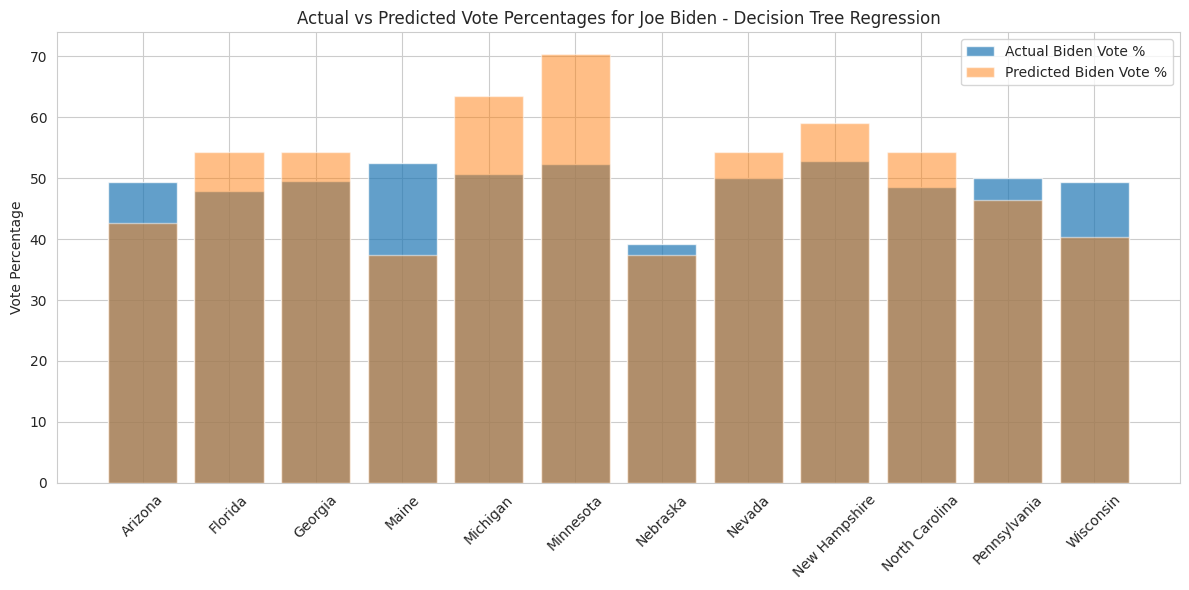

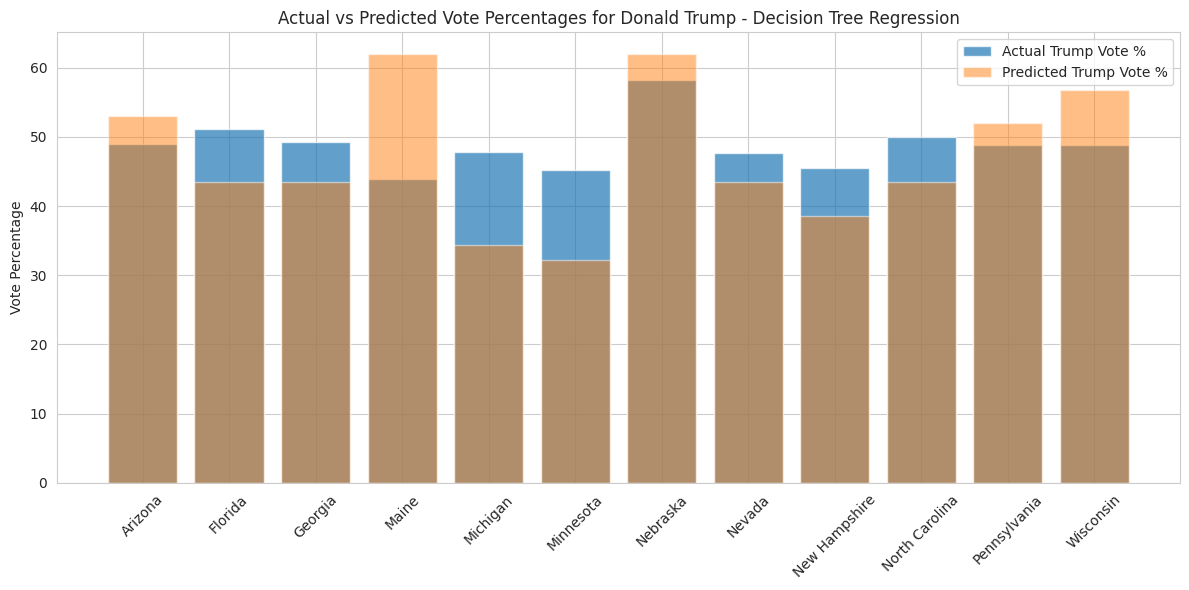

Random Forest Regression Mean Squared Error for Biden: 25.632
Random Forest Regression Mean Squared Error for Trump: 13.609


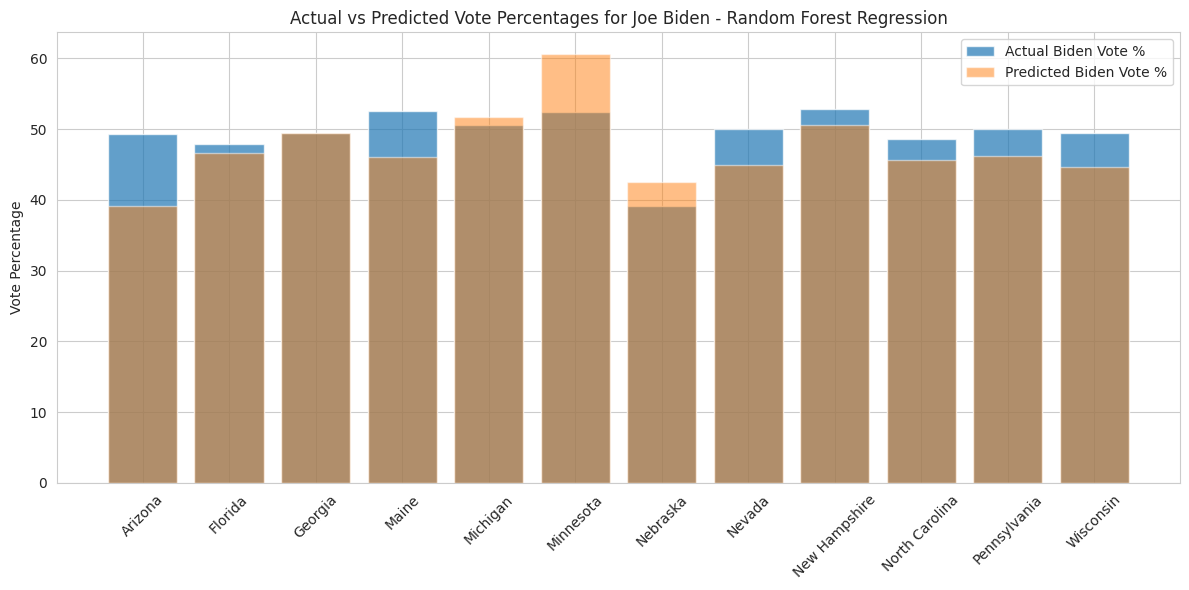

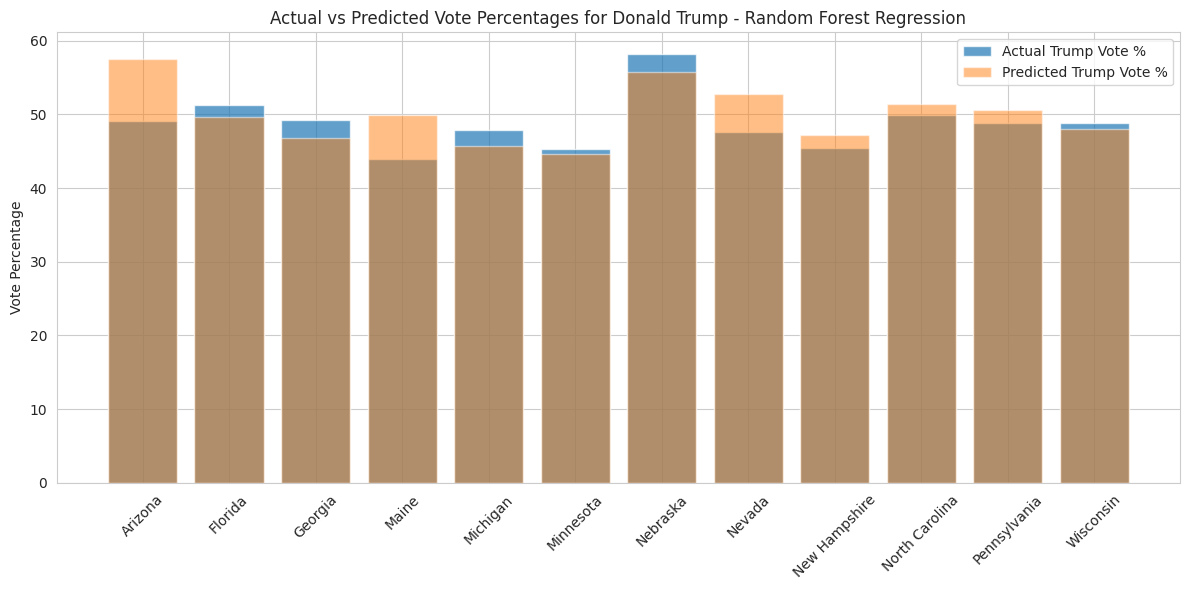

Gradient Boosting Regression Mean Squared Error for Biden: 58.022
Gradient Boosting Regression Mean Squared Error for Trump: 33.561


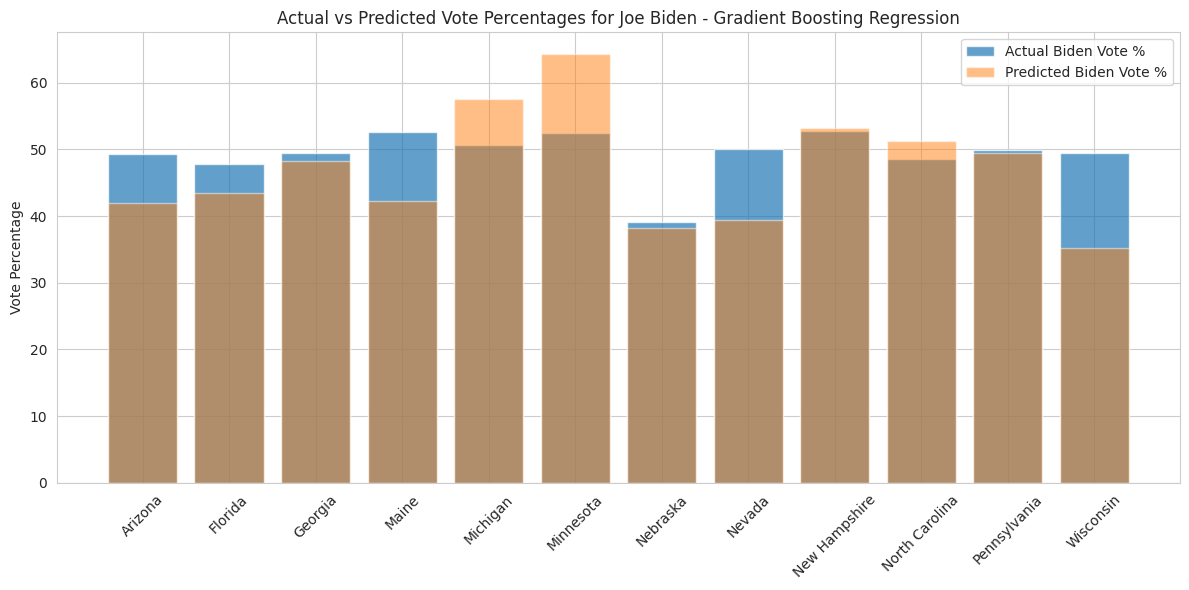

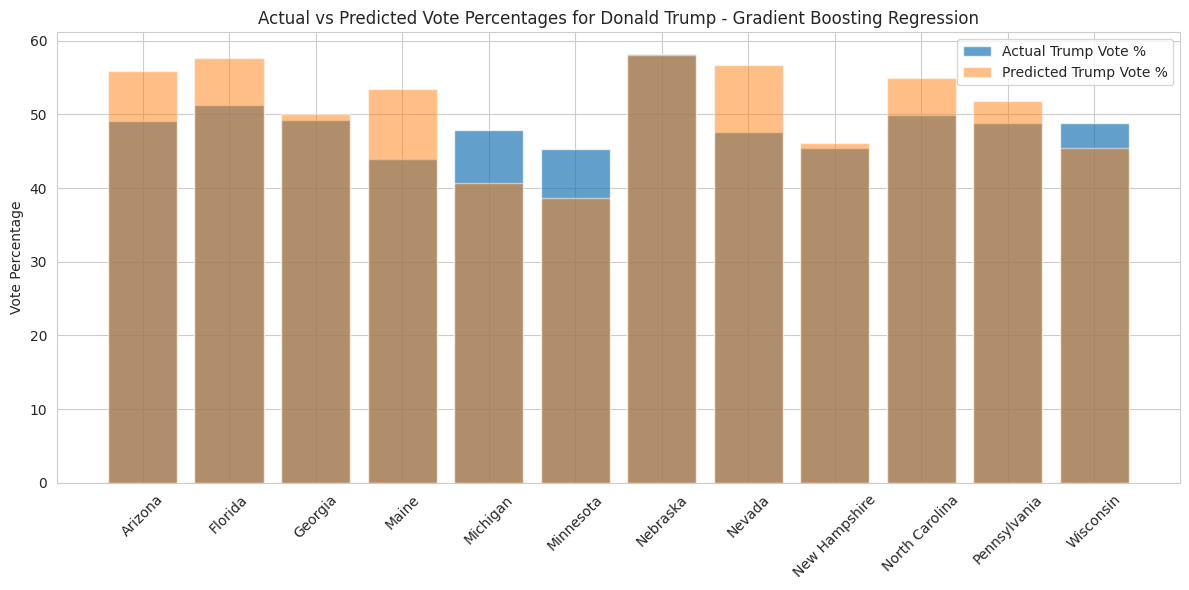

In [ ]:
for model_name, model in models_multi.items():
    train_and_evaluate_model(model, training_set, test_set, model_name)